In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cm
from pathlib import Path
from topostats.io import LoadScans
import topostats.filters as topofilters
from topostats.utils import get_mask
from scipy.optimize import least_squares
from scipy.interpolate import splprep, splev
from skimage.filters import gaussian
from scipy.spatial import distance
from skimage import io, color, morphology, transform, feature, filters
from skimage.io import imread
from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line
from skimage.color import rgb2gray
from scipy import ndimage
from scipy.spatial.distance import cdist
from skimage.morphology import label
from skimage import draw
import csv

In [3]:
def plot(image: np.ndarray, title: str=None, zlimit: bool=True, figsize: tuple=(8, 8), **kwargs) -> None:
    fig, ax = plt.subplots(figsize=figsize)
    if zlimit == True:
        vmin=-3
        vmax=4
    else:
        vmin=None
        vmax=None
    ax.imshow(image, vmin=vmin, vmax=vmax, **kwargs)
    if title is not None:
        ax.set_title(title)
    plt.show()

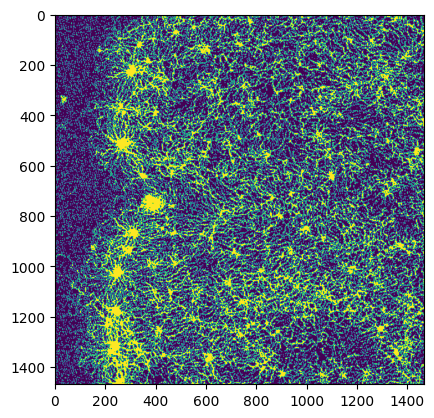

In [39]:
I = imread('./PristineZoom/KPN005.0_00013(crop).png')[:,:,:3]
Igray = color.rgb2gray(I)
plt.imshow(Igray)
# We will clean it up with a few morphological operations
strand_mask = Igray > filters.threshold_otsu(Igray)
plt.imshow(strand_mask)


[Sun, 30 Apr 2023 18:25:54] [INFO    ] [topostats] Extracting image from EP_Zoom\20230419_EPN005_Metal.0_00009.spm
[Sun, 30 Apr 2023 18:25:54] [INFO    ] [topostats] Loading image from : EP_Zoom\20230419_EPN005_Metal.0_00009.spm
[Sun, 30 Apr 2023 18:25:54] [INFO    ] [topostats] [20230419_EPN005_Metal.0_00009] : Loaded image from : EP_Zoom\20230419_EPN005_Metal.0_00009.spm
[Sun, 30 Apr 2023 18:25:54] [INFO    ] [topostats] [20230419_EPN005_Metal.0_00009] : Extracted channel Height
[Sun, 30 Apr 2023 18:25:54] [INFO    ] [topostats] [20230419_EPN005_Metal.0_00009] : Pixel to nm scaling : 3.2958984375
[Sun, 30 Apr 2023 18:25:54] [INFO    ] [topostats] [EP_Zoom\20230419_EPN005_Metal.0_00009.spm] : Median flattening without mask
[Sun, 30 Apr 2023 18:25:54] [INFO    ] [topostats] [EP_Zoom\20230419_EPN005_Metal.0_00009.spm] : Plane tilt removal without mask
[Sun, 30 Apr 2023 18:25:55] [INFO    ] [topostats] [EP_Zoom\20230419_EPN005_Metal.0_00009.spm] : x-polyfit 1st order: [  0.14052148 -35.7

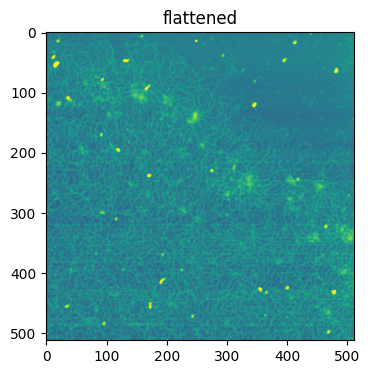

thresholds: defaultdict(None, {'upper': 0.47439075077482756})
[Sun, 30 Apr 2023 18:25:58] [INFO    ] [topostats] [None] : Masking (upper) Threshold: 0.47439075077482756


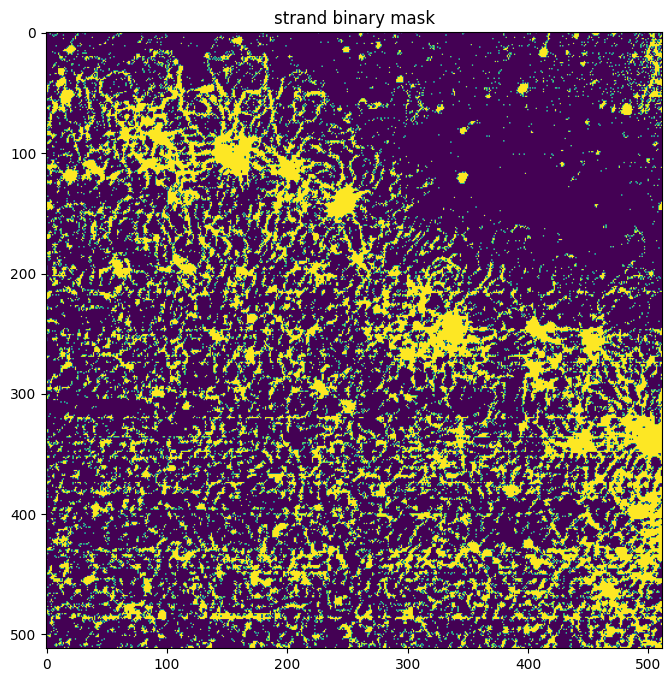

In [9]:
#SPM Import and Flatten

    #Zoom
#file = Path('./PristineZoom/20230126_KPN005_25mMMgCl2_Vac_24hr.0_00006.spm')
#file = Path('./PristineZoom/20230125_KPN005_25mMMgCl2_Vac.0_00014.spm')
file = Path('./EP_Zoom/20230419_EPN005_Metal.0_00009.spm')
loadscans = LoadScans([file], 'Height')
loadscans.get_data()
p_to_nm = loadscans.pixel_to_nm_scaling
image_raw = loadscans.image
#plt.imshow(image_raw)

filters = topofilters.Filters(
    image = image_raw,
    filename = file,
    pixel_to_nm_scaling = p_to_nm,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 0.5, 'lower': None},
    gaussian_size=1.0,
    remove_scars={'run': False}
)

filters.filter_image()

flattened = filters.images['zero_average_background']
plot(flattened, title='flattened',figsize=(4,4))

strand_thresholds = topofilters.get_thresholds(
    flattened,
    threshold_method='std_dev',
    threshold_std_dev={'upper': 0.5, 'lower': None}
)

print(f'thresholds: {strand_thresholds}')
strand_mask = topofilters.get_mask(image=flattened, thresholds=strand_thresholds)
strand_mask = gaussian(strand_mask.astype(bool), 0.1)

plot(strand_mask.astype(bool), title='strand binary mask', zlimit=False)

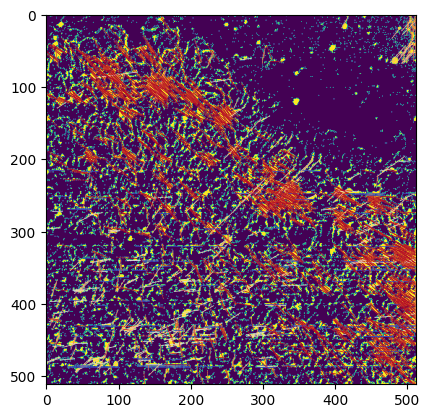

In [10]:
lines = probabilistic_hough_line(strand_mask, threshold=10, line_length=15, line_gap=3)

# Plot the lines on top of image marking the beginning and end
angles = []

#Colour Map
values = np.linspace(0, 100, 100)
norm = clrs.Normalize(vmin=-2, vmax=2, clip=True)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.coolwarm_r)

plt.imshow(strand_mask)
for line in lines:
    p0, p1 = line
    theta = np.arctan2(p1[1] - p0[1], p1[0] - p0[0])
    angles.append(theta)
    mp_color = mapper.to_rgba(theta)
    plt.plot((p0[0], p1[0]), (p0[1], p1[1]), '-', linewidth=0.5, color=mp_color)



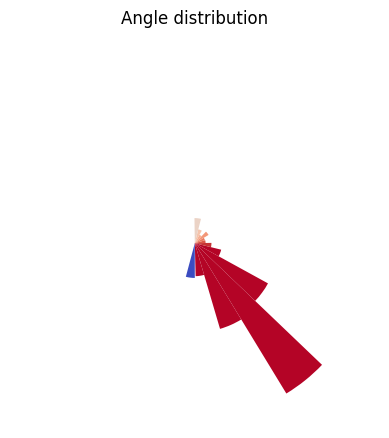

In [11]:
plt.figure()
ax = plt.subplot(111, projection='polar')
cnts, values, bars = ax.hist(angles, bins=24, color='blue', density=True)
ax.set_theta_zero_location('N')
ax.set_theta_direction(1)
plt.title('Angle distribution')
plt.axis('off')
for (cnt, value, bar) in zip(cnts, values, bars):
    bar.set_facecolor(mapper.to_rgba(value))
plt.show()